## Importing the Data

In [1]:
# Constants
DATASET_DIR = './data/' # Datasets to be places here
SAVE_DIR = './' # Main Dir
WORD2VEC_DIR = './word2vec/' # Pretrained Word2vec model
GOVE_DIR = './glove/' # Pretrained glove model

import os
import pandas as pd
import numpy as np

""" Attribute Reduction """
# Removing empty columns and finding minimum and maximum scores given to each of the 8 sets

X = pd.read_csv(os.path.join(DATASET_DIR, 'training_set_rel3.tsv'), sep='\t', encoding='ISO-8859-1')
# Reading from tsv file (tab - separated) with Latin alphabet encoding including special symbols
y = X['domain1_score']
X = X.dropna(axis=1)
X = X.drop(columns=['rater1_domain1', 'rater2_domain1'])
Z = pd.read_excel(r'./data/essay_set_descriptions.xlsx')

# minimum and maximum scores for each dataset
minimum_scores = Z['min_domain1_score'].to_list()
minimum_scores.insert(0,-1)
maximum_scores = Z['max_domain1_score'].to_list()
maximum_scores.insert(0,-1)

print()
print(minimum_scores)
print(maximum_scores)

In [46]:
X

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8
...,...,...,...,...
12971,21626,8,In most stories mothers and daughters are eit...,35
12972,21628,8,I never understood the meaning laughter is th...,32
12973,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",40
12974,21630,8,Trippin' on fen...,40


## Pre-processing of the Data

These are all helper functions used to clean and tokenize the essays.

In [4]:
# !pip install gensim
# !pip install nltk
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('popular')
import re # for regular expressions operations 
from nltk.corpus import stopwords

def essay_to_wordlist(essay_v, remove_stopwords):
    # remove the tagged labels and word tokenize the sentence
    essay_v = re.sub("[^a-zA-Z]", " ", essay_v) # removing anything that is not alphabetic
    words = essay_v.lower().split() # turn sentence into lowercase and split it into words 
    if remove_stopwords:
        stops = set(stopwords.words("english")) # english stopwords library 
        words = [w for w in words if not w in stops] # words present in the sentence and not present in stopwords
    return (words)

def essay_to_sentences(essay_v, remove_stopwords):
    # sentence tokenize the essay and call essay_to_wordlist() for word tokenization
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle') # nltk library
    raw_sentences = tokenizer.tokenize(essay_v.strip()) # call tokenizer on essay striped of spaces 
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(essay_to_wordlist(raw_sentence, remove_stopwords))
            # remove_stopwords carried forward to essay_to_wordlist it is a bool variable
    return sentences # will be returning list of tokenized sentences without stopwords

## Word2Vec Model

We will preprocess all essays and convert them to feature vectors.

In [5]:
from gensim.models import Word2Vec # for word2vec
from gensim.test.utils import get_tmpfile

def makeFeatureVec(words, model, num_features):
    # make Feature Vector from the words list of an Essay
    featureVec = np.zeros((num_features,),dtype="float32")
    #  make null vectors of length = num_features for every word index
    num_words = 0.
    index2word_set = set(model.wv.index2word) # vocabulary set of model
    for word in words:
        if word in index2word_set: # for word in a sentence being in index2word_set
            num_words += 1
            featureVec = np.add(featureVec,model[word])
    if num_words:
        featureVec = np.divide(featureVec,num_words) 
        # divides every element of featureVec by num_words (to compute average) 
    return featureVec

def getAvgFeatureVecs(essays, model, num_features):
    # main function to generate the word vectors for word2vec model
    # it then calls makeFeatureVec and for every essay sentance
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features),dtype="float32")
    # make null vectors of length = length of essay having null vector of num_features at every index
    for essay in essays:
        essayFeatureVecs[counter] = makeFeatureVec(essay, model, num_features)
        counter = counter + 1
    return essayFeatureVecs
    # then returns the trained model feature vectors
    
allsentences = [] # list of all sentences
    
for essay in X['essay']:
# obtaining all sentences from the essays.
    allsentences += essay_to_sentences(essay, remove_stopwords = True)
            
# initializing variables for word2vec model.
num_features = 300 # vector length
min_word_count = 40 # to be considered for vectorisation
num_workers = 8 # working cores
context = 10
downsampling = 1e-3 # compressing

# for visualization of vectors
visualmodel = Word2Vec(allsentences, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)

path = get_tmpfile("./word2vecvis/word2vecvisual.model") # path for the model 

visualmodel.init_sims(replace=True) # normalized model
# different ways to save model
visualmodel.wv.save_word2vec_format('./word2vecvis/word2vecvisual.txt', binary=False)
visualmodel.wv.save_word2vec_format('./word2vecvis/word2vecvisual.bin', binary=True)
visualmodel.save("./word2vecvis/word2vecvisual.model")

M=visualmodel[visualmodel.wv.vocab]
df=pd.DataFrame(M)
df.head()

## Pre-Trained Word2Vec Model

In [6]:
from gensim.models import KeyedVectors

modelbasic = Word2Vec.load('./word2vecvis/word2vecvisual.model')
total_examples = modelbasic.corpus_count
# Getting embeddings from pretrained word2vec model 
modelbasic.intersect_word2vec_format('./word2vec/word2vec.bin', binary=True, lockf=1.0)
modelbasic.train(allsentences,total_examples=total_examples, epochs=modelbasic.iter)
modelbasic.save("./word2vec/word2vecPre.model")

## Pre-Trained Glove Model

In [7]:
from gensim.scripts.glove2word2vec import glove2word2vec

modelglove = Word2Vec.load('./word2vecvis/word2vecvisual.model')
total_examples = modelglove.corpus_count
# Converting Glove to Word2Vec
_ = glove2word2vec('./glove/glove.6B.300d.txt', "./glove/gloveW2V.txt")
# Getting embeddings from pretrained Glove model
modelglove.intersect_word2vec_format('./glove/gloveW2V.txt', binary=False, lockf=1.0)
modelglove.train(allsentences,total_examples=total_examples, epochs=modelbasic.iter)
modelglove.save("./glove/gloveW2V.model")

## Fasttext

## Pre-Trained Fasttext Model

## Visualization

In [8]:
# Storing Visual model tsv files
import io # for input output

# files needed for tensorboard
out_v = io.open('./word2vecvis/vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('./word2vecvis/meta.tsv', 'w', encoding='utf-8')

# write meta file and vector file
for index in range(len(visualmodel.wv.index2word)): # for every word in vocab
    word = visualmodel.wv.index2word[index]
    vec = visualmodel.wv.vectors[index]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()

# Open http://projector.tensorflow.org/
# Click “Load Data” button from the left menu.
# Select “Choose file” in “Load a TSV file of vectors.” and choose “vecs.tsv” file.
# Select “Choose file” in “Load a TSV file of metadata.” and choose “meta.tsv” file.
# The model has been visualized in 3D/2D.
# It is done on choosing variable with higher variance as a dimension from the vector

## Exploratory Analysis


 300.0000000000007

1. Variance Explained
 [14.308799252197298, 10.48189443265591, 7.444248068244565, 6.5974209187139286, 6.125706987673272]

2. Cumulative Variance Explained
 [14.30879925 24.79069368 32.23494175 38.83236267 44.95806966]

 [[ 0.20821657 -0.06537722]
 [ 0.06223931  0.17626966]
 [ 0.25704037  0.14617903]
 ...
 [-0.62368442  0.20154138]
 [-0.35027146  0.19836701]
 [-0.10150704  0.08983075]]


<BarContainer object of 5 artists>

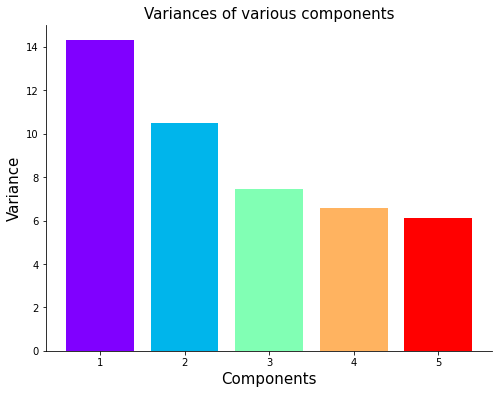

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Computing the correlation matrix
M_corr=df.corr()

#Computing eigen values and eigen vectors
values,vectors=np.linalg.eig(M_corr)


# Sorting the eigen vectors coresponding to eigen values in descending order is done like this to have us choosing best eigenvector # for infogain. But in our model its already sorted the way it should be. Eigenvector with highest eigenvalue in the first column.

# args = (-values).argsort()
# values = vectors[args]
# vectors = vectors[:, args]


# our aim is to cover maximum variance possible 
# no. of components selected = no. of plotting dimensions
tot = sum(values) # summation of eigenvalues
print("\n",tot) 
var_exp = [(i / tot)*100 for i in values[:5]] # first 5 variance in desc order
print("\n1. Variance Explained\n",var_exp) 
cum_var_exp = np.cumsum(var_exp) # first 5 cumulative variance
print("\n2. Cumulative Variance Explained\n",cum_var_exp) 
# as we can see % of variance the first two principal components each contain 13 , 12
# these components together contain 23

#Taking first 2 components which explain maximum variance for projecting
new_vectors=vectors[:,:2]

new_M=np.dot(M,new_vectors)
print("\n",new_M) # coordinates for 2D plot

plt.figure(figsize=(8,6))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title('Variances of various components',size=15)
plt.xlabel("Components",size=15)
plt.ylabel('Variance',size=15)
plt.bar(range(1,6),
        var_exp,
        width=0.8,
        color = cm.rainbow(np.linspace(0, 1, len(var_exp))))

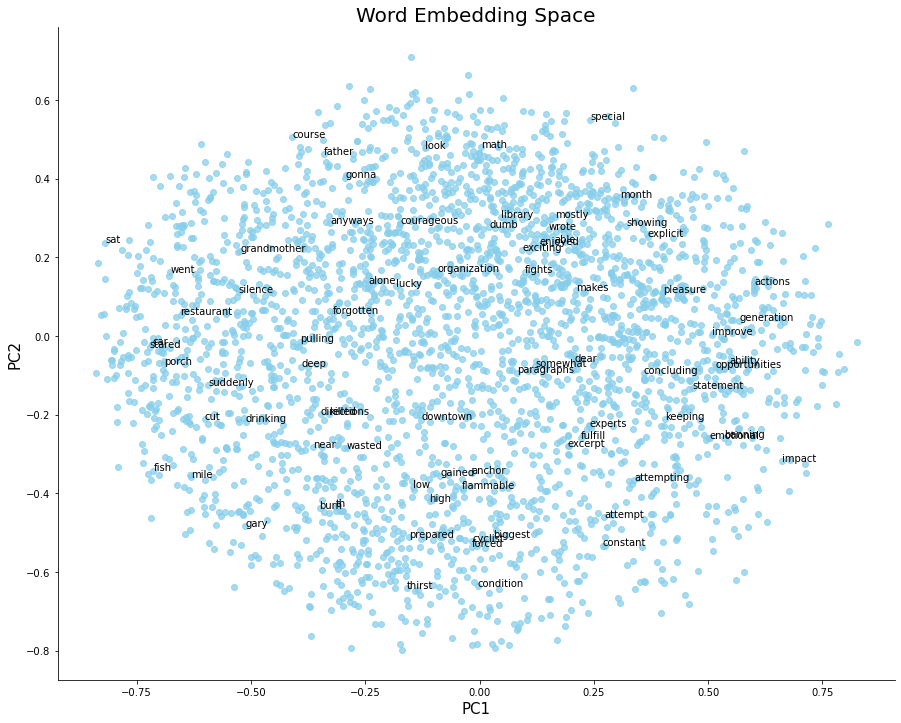

In [11]:
#Plotting
plt.figure(figsize=(15,12))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.scatter(new_M[:,0],new_M[:,1],linewidths=1,color='skyblue',alpha=0.75)
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("Word Embedding Space",size=20)
vocab=list(visualmodel.wv.vocab)
for i, word in enumerate(vocab):
  if i%37==0:
      plt.annotate(word,xy=(new_M[i,0],new_M[i,1])) # selective annotations
  

## Defining the model 

In [12]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D
from keras.models import Sequential
import keras.backend as K

# bidirectional is for evaluating input in both sequential order
# conv1D is for adding a Cnn layer instead of a LSTM layer
# return sequences return sequences in shape for next Lstm layer
# dropout layers are for regularization
# dropout is for inputs and recurrent dropout is for recurrent inputs
# instead of using sigmoid activation in the output layer we will use Relu since we are not normalising training labels.
# x is 0-> Dual layer LSTM, 1-> Bidirectional LSTM, 2-> CNN LSTM 

def get_model(x):
    model = Sequential()
    if x == 0:
        model.add(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True))
    if x == 1:
        model.add(Bidirectional(LSTM(300, dropout=0.4, recurrent_dropout=0.4, input_shape=[1, 300], return_sequences=True)))
    if x == 2:
        model.add(Conv1D(64, 3, activation='relu',input_shape=(1,300),padding='same'))
        model.add(Dropout(0.4))
    model.add(LSTM(128, recurrent_dropout=0.4))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu')) 
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    if x == 1:
        model.build((None,1,300))
    model.summary()
    return model

## Training Phase

(9083, 4) (9083,)
(3893, 4) (3893,)
Training Word2Vec Model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 300)            721200    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 940,977
Trainable params: 940,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
284/284 [==============================] - 5s 17ms/step - loss: 48.8436 - mae: 3.8993 - val_loss: 24.4543 - val_mae: 2.9486
Epoch 2/100
284/284 [==========================

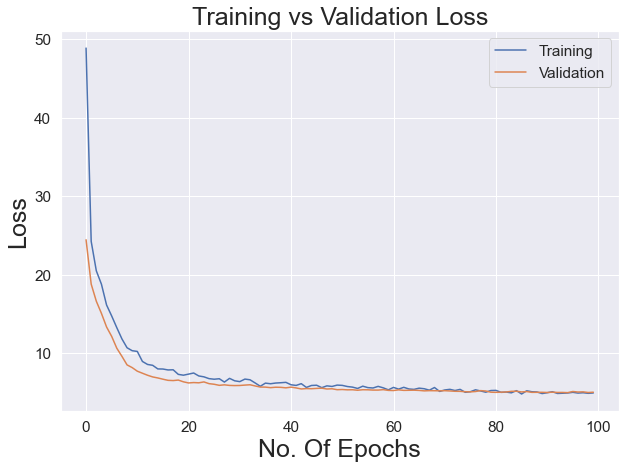

Kappa Score: 0.9657113186180061


In [373]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import cohen_kappa_score
    
X_train,X_test,y_train,y_test = train_test_split(X, y, train_size=0.70,test_size=0.30, random_state=0)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
    
train_essays = X_train['essay']
test_essays = X_test['essay']
   
sentences = []
    
for essay in train_essays:
    # Obtaining all sentences from the training essays.
    sentences += essay_to_sentences(essay, remove_stopwords = True)
            
# Initializing variables for word2vec model.
num_features = 300 
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3

print("Training Word2Vec Model...")
model = Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count, window = context, sample = downsampling)

model.init_sims(replace=True) # Normalizing Word2Vec

clean_train_essays = []
    
# Generate training and testing data word vectors.
for essay_v in train_essays:
    clean_train_essays.append(essay_to_wordlist(essay_v, remove_stopwords=True))
trainDataVecs = getAvgFeatureVecs(clean_train_essays, model, num_features)
    
clean_test_essays = []
for essay_v in test_essays:
    clean_test_essays.append(essay_to_wordlist( essay_v, remove_stopwords=True ))
testDataVecs = getAvgFeatureVecs( clean_test_essays, model, num_features )
    
trainDataVecs = np.array(trainDataVecs)
testDataVecs = np.array(testDataVecs)
# Reshaping train and test vectors to 3 dimensions. (1 represnts one timestep)
trainDataVecs = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
    
lstm_model = get_model(0)
history = lstm_model.fit(trainDataVecs, y_train,validation_data=(testDataVecs,y_test) ,batch_size=32, epochs=2,shuffle = False) # fitting

# This can be used for prediction
# lstm_model.load_weights('./final_lstm.h5') To load model weight
# Predicting from test data
y_pred = np.around(lstm_model.predict(testDataVecs))  
# lstm_model.save('./final_lstm.h5')

# Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
result = cohen_kappa_score(y_test.values,y_pred,weights='quadratic')

plt.figure(figsize=(10,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training vs Validation Loss', size=25)
plt.ylabel('Loss', size=25)
plt.xlabel('No. Of Epochs', size=25)
plt.legend(['Training','Validation'], loc= 'upper right' )
plt.show()

print("Kappa Score: {}".format(result))

        

## Implementing Multinomial Naive Bayes from Scratch


In [371]:
import math as ma
import itertools # this is to slice the dictionary to get only max frequecvy values
from nltk.tokenize import word_tokenize # used to tokenize the sentences
stop_words = set(stopwords.words('english'))

def probability(dictionary,x,score): # it returns the actual probability of input x over class clas

    count=ma.log(dictionary[score]["count"])-ma.log(dictionary["total"]) # it is probability for a certain score
    features_number=len(dictionary[score].keys())-2 # total number of features
    for j in range(features_number): # calculting the probabilty over each feature the later we will take log() sum of all       
        if(x[j]==0): # if input x have zero frequency over the feature so its probability will not counted
            continue
        count_xj_in_feature_j=dictionary[score][j] + 1 # it is the total frequency of feature j in a score
        # adding one to eliminate any domain specific errors
        count_clas_ele_in_feature=dictionary[score]["Grand_total"] # it is total number of words in a score
        p=ma.log(count_xj_in_feature_j)-ma.log(count_clas_ele_in_feature) 
        # summing all small probabilities of all features
        count=count+p
    return count # returning the probabilty

def singlecol(dictionary,x): # singlecol gives the prediction(output) of single colum at a time
    
    best_prob=-1 # giving any value to initialise best_prob
    best_cls=-1 # giving any value to initialise best_cls
    classes=dictionary.keys() # dictionary .keys have all the classes names
    val=True
    for clas in classes: # checking probabily on one class at a time 
        if clas=="total": # total is not a class so ignore it
            continue
        clas_p=probability(dictionary,x,clas) # clas_p will have probability of input x for class clas
        if(val or clas_p>best_prob):
            best_prob=clas_p
            best_cls=clas
        val=False
    return best_cls

X_naive = X['essay'].tolist()
Y_naive = X['domain1_score'].tolist()
sets = X['essay_set'].tolist()

for i in range(len(sets)):
    Y_naive[i]=Y_naive[i]-minimum_scores[sets[i]]
    Y_naive[i]=int(np.around((Y_naive[i]*5)/(maximum_scores[sets[i]]-minimum_scores[sets[i]])))

# doing hold out spliting for train and test data
xtrain,xtest,ytrain,ytest=model_selection.train_test_split(X_naive,score,test_size=0.3,random_state=0)

len_data=len(xtrain)

# in this dictionary we will store frequency of each word from entire dataset by removing stop_words
dictionary=dict()
for j in range(len_data):
    data=xtrain[j]
    word_tokens = word_tokenize(data)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    for word in filtered_sentence:
        if word in dictionary:
            dictionary[word]+=1
        else:
            dictionary[word]=1

# slicing over bigger ditionary to get max  frequency 3000 data only
a=dict(itertools.islice(new_dict.items(),3000))
     
features=[] # features is the list of keys of dictionary (a) 
for i in a.keys():
    features.append(i)

# modifing x_train and x_test to 2d Lists having frequency of each word of features 
xx_train=np.zeros((len(xtrain),len(features)))
for i in range(len(xtrain)):
    data=xtrain[i]
    
    word_tokens = word_tokenize(data)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    for j in filtered_sentence:
        if j in features:
            xx_train[i][features.index(j)]+=1
            
xx_test=np.zeros((len(xtest),len(features)))
for i in range(len(xtest)):
    data2=xtest[i]
    word_tok=word_tokenize(data2)
    
    fil_sentence = [w for w in word_tok if not w in stop_words]
    
    for j in fil_sentence:
        if j in features:
            xx_test[i][features.index(j)]+=1

# this is to train algorithm over training data
result={} # we will use dictionary and create nested dictionary where needed
classes=set(ytrain)

for current_class in classes: # accessing all score classes one by one 
    x_train_current =[]   
    y_train_current =[]
    result[current_class]={}
    result["total"]=len(xx_train) # it will hold length of entire xx_train set
    for i in range(len(ytrain)):
        if score[i]==current_class:
            x_train_current.append(xx_train[i])
            y_train_current=score[i] # spliting y_train for only current_class
    
    result[current_class]["count"]=len(x_train_current) # it will hold count of current_class
    features_total=xx_train.shape[1] # feature size is nothin but the columns of xx_train
    a=0
    for j in range(len(features)):
        result[current_class][j]=0
        for k in range(len(x_train_current)):
            result[current_class][j]+=x_train_current[k][j]  # it will hold frequency of feature j
        a+=result[current_class][j]
    result[current_class]["Grand_total"]=a  # it will hold count of entire words in current_class
    
ypred=[]
for x in xx_test: # going through test_data row wise
    pred=singlecol(result,x) # as we get a answer by one column we are appending it to list
    ypred.append(pred)    

from sklearn.metrics import classification_report,confusion_matrix
#importing these to check correctness of y_pred(output)
print(classification_report(ytest,ypred))
print()
print('-----------------COMPARISION-----------------')
print()
print('This classification is due to sklearn library')
print()
from sklearn.naive_bayes import MultinomialNB          # now doing the same fit and predict by MultinomialNB library function
arg1=MultinomialNB()
arg1.fit(xx_train,ytrain)
ypred2=arg1.predict(xx_test)

print(classification_report(ytest,ypred2))

              precision    recall  f1-score   support

           0       0.00      0.02      0.01       124
           1       0.04      0.13      0.06       235
           2       0.41      0.24      0.30      1188
           3       0.18      0.13      0.15      1138
           4       0.12      0.06      0.08       793
           5       0.07      0.06      0.07       415

    accuracy                           0.14      3893
   macro avg       0.14      0.11      0.11      3893
weighted avg       0.21      0.14      0.16      3893


-----------------COMPARISION-----------------

This classification is due to sklearn library

              precision    recall  f1-score   support

           0       0.17      0.61      0.27       124
           1       0.35      0.41      0.38       235
           2       0.48      0.19      0.28      1188
           3       0.53      0.42      0.47      1138
           4       0.48      0.28      0.35       793
           5       0.26      0.84    

## Confusion Matrix for Naive Bayes 

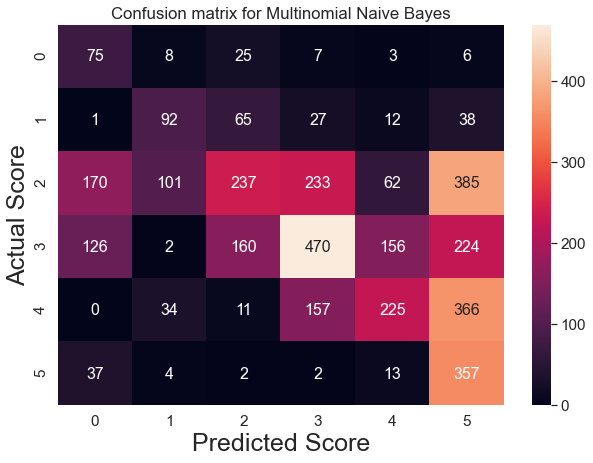

In [365]:
import seaborn as sns

plt.figure(figsize=(10,7))
array = confusion_matrix(ytest,ypred2)
df_cm = pd.DataFrame(array, range(6), range(6))
fig = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='d') # font size
sns.set(font_scale=1.4) # for label size
plt.xlabel("Predicted Score", size=25)
plt.ylabel("Actual Score", size=25)
plt.title("Confusion matrix for Multinomial Naive Bayes") # You can comment this line out if you don't need title
plt.show(fig)